In [18]:
import glob
#from pathlib import Path
import json
import preprocessing as pp
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

In [22]:
keys_to_dtype = {
  #'developer_token_id': tf.int64,
  #'resource_token_id': tf.int64,
  #'screen_caption_token_ids': tf.int64,
  #'appdesc_token_id': tf.int64,
  'clickable_seq': tf.int64,
  'type_id_seq': tf.int64,
  'cord_x_seq': tf.float32,
  'cord_y_seq': tf.float32,
  'visibility_to_user_seq': tf.int64,
  'visibility_seq': tf.int64,
  #'attended_objects': tf.int64,
  #'label_flag': tf.int64,  # 0: padding 1: node
  # 'obj_img_mat': tf.int64,
  'obj_dom_pos': tf.int64,
  #'attention_boxes': tf.float32,
  #'gold_caption': tf.string,
}

In [23]:
def get_features_from_gestures(gesture_path):
  with tf.io.gfile.GFile(gesture_path) as f:
    gesture_json = json.load(f)
  trace_path = gesture_path.replace('gestures.json', '')
  # Throw away all gestures except the first
  gesture_items = list(gesture_json.items())
  # Remove empty gestures
  gesture_items = [gesture for gesture in gesture_items if gesture[1]]
  # TODO: Add column: isSwipe, if gesture has more than one entry
  if gesture_items and gesture_items[0]:
    gesture_dict = {gesture[0]:gesture[1][0] for gesture in gesture_items}
  else:
    gesture_dict = {}

  first_gesture_item = list(gesture_dict.items())
  if (not gesture_dict) or (not first_gesture_item[0]) or (not first_gesture_item[0][1]):
    # Return empty dataframe, if no data is available
    return pd.DataFrame(columns=['x', 'y']), trace_path
  
  gesture_df = pd.DataFrame(gesture_dict).transpose()
  gesture_df.columns = ['x', 'y']
  return gesture_df, trace_path

In [24]:
# def to_var_len_feature_dict(entries):
#   dict = {}
#   for feature_item in entries:
#     dict[feature_item[0]] = tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])
#   return dict


In [25]:
#pathToCombined = "D:/Tmp/Coding/datasets/RICO/unique_uis/test_dataset"
traces_prefix = "../sources/datasets/RICO/traces/filtered_traces"
path_to_gesture_json = f"{traces_prefix}/*/trace_*/gestures.json"
path_to_gesture_json

'../sources/datasets/RICO/traces/filtered_traces/*/trace_*/gestures.json'

In [26]:
gesture_json_paths = glob.glob(path_to_gesture_json)
len(gesture_json_paths)

10292

In [27]:
def get_features_from_tree(frame_index, trace_path):
  file_prefix = f"{trace_path}view_hierarchies/{frame_index}"
  features_dict = pp.create_simple_features(file_prefix)
  if features_dict is None:
    return None
  del features_dict['node_id']
  feature_items = list(features_dict.items())
  #feature_items = to_var_len_feature_dict(feature_items).items()
  tree_feature_df = pd.DataFrame(feature_items, columns=['feat', frame_index])
  tree_feature_df = tree_feature_df.set_index('feat')
  tree_feature_df = tree_feature_df.transpose()
  return tree_feature_df
  #return pd.DataFrame(features_adapt, index=[frame_index])

In [28]:
gesture_path = gesture_json_paths[42]
gesture_df, trace_path = get_features_from_gestures(gesture_path)
frameIndex = gesture_df.index.values[0]
feature_df = get_features_from_tree(frameIndex, trace_path)
feature_df
#feature_item = features[0]
#feature_item
#tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])

feat,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq,cord_y_seq
432,"[1, 1, 68, 2, 2, 67, 2, 67, 2, 2, 68, 1, 3, 3,...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],..."


In [29]:
# gesture_df['x'].dtype # float64
# gesture_df['y'].dtype # float64

In [30]:
# for t,v in keys_to_dtype.items():
#     print(feature_df[t]['4758'][0].dtype)

In [31]:
# Try without features for now, only gestures
all_feat_df = pd.concat([gesture_df, feature_df], axis=1)
#all_feat_df = gesture_df
all_feat_df

,x,y,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq,cord_y_seq
432,0.407648,0.272727,"[1, 1, 68, 2, 2, 67, 2, 67, 2, 2, 68, 1, 3, 3,...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],..."
514,0.848244,0.890693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
705,0.063252,0.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
947,0.430736,0.405844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2172,0.072872,0.068182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2212,0.242184,0.337662,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#feature_df['type_id_seq'].iloc[0][0].dtype

In [33]:
length = 5
n_features=2
label_length=1
training_frames = length + label_length

In [34]:
 # Get set of frames for each screen, but don't mix them during training LSTM
feature_traces = pd.DataFrame()
use_embeddings = True

trace_progress = 0
for trace_id, gesture_path in enumerate(gesture_json_paths):
    trace_progress = trace_progress + 1
    if trace_progress % 100 == 0:
      print(f'Processed {trace_progress} of {len(gesture_json_paths)} ({trace_progress/len(gesture_json_paths):.0%}) traces.\r', end="")
    gesture_df, trace_path = get_features_from_gestures(gesture_path)
    # Traces with too few frames will be dropped
    if len(gesture_df) < training_frames:
        #print(f'Gesture (traceID: {trace_id}) has only {len(gesture_df)} of {training_frames} required frames: {gesture_path}')
        continue
    if use_embeddings: # Try without features for now, only gestures
        tree_features_df = pd.DataFrame()
        for frame_id in gesture_df.index.values:
            tree_feature_df = get_features_from_tree(frame_id, trace_path)
            if tree_feature_df is None:
              print(f'Frame {frame_id} has no feature data')
              continue
            tree_features_df = pd.concat([tree_features_df, tree_feature_df], axis=0)
        trace_features_df = pd.concat([gesture_df, tree_features_df], axis=1)
    else:
        trace_features_df = gesture_df
    trace_features_df['trace_id'] = trace_id
    feature_traces = pd.concat([feature_traces, trace_features_df], axis=0)

len(feature_traces)
        

KeyboardInterrupt: 

In [ ]:
feature_traces.head()

In [ ]:
feature_traces.describe()

In [ ]:
import math
import statistics

# Preprocess data
feature_traces_preprocessed = feature_traces
print(len(feature_traces_preprocessed))
feature_traces_preprocessed = feature_traces_preprocessed.dropna()
feature_traces_preprocessed = feature_traces_preprocessed[['x','y', 'obj_dom_pos', 'trace_id']]
print(len(feature_traces_preprocessed))
# for t,v in keys_to_dtype.items():
#   # try to convert float to list
#   feature_traces_preprocessed[t] = feature_traces_preprocessed[t].apply(lambda x : [np.nan if (y is None or isinstance(y, float)) else y for y in x] if isinstance(x, list) else [x])
# 
# #lens of list
# print(feature_traces_preprocessed.isna().sum())
# feature_traces_preprocessed

# List of median value count for each feature.
feat_median_array_length = {}

# Check if feature is an array
isFeatList = (feature_traces_preprocessed.map(type) == list).all(axis='rows')
max_dom_pos = 500 # see screen2words
for feat_name, isList in isFeatList.items():
  if isList:
    median_value = statistics.median(feature_traces_preprocessed[feat_name].map(len))
    feat_median_array_length[feat_name] = median_value
    print(f'Preprocess "{feat_name}" with median array length of {median_value}')
    # Remove all NaN
    feature_traces_preprocessed[feat_name] = feature_traces_preprocessed[feat_name].map(lambda row: [x for x in row if not math.isnan(x)])
    # Pad all values to same length
    feat_pad = keras.utils.pad_sequences(feature_traces_preprocessed[feat_name], value=0, padding='post', maxlen=max_dom_pos)
    print(f'Feature "{feat_name}" has max array length of {len(feat_pad[0])}')
    feature_traces_preprocessed[feat_name] = feat_pad.tolist()

feat_median_array_length

In [ ]:
# feature_traces_flatten = feature_traces_preprocessed
# for feat_name, isList in isFeatList.items():
#   if isList:
#     max_len = len(feature_traces_flatten[feat_name])
#     feature_traces_flatten = feature_traces_flatten.drop(feat_name, axis= 1)
#     feature_traces_flatten[[f'{feat_name}_{i}' for i in max_len]] = pd.DataFrame(feature_traces_preprocessed[feat_name].tolist(), index= feature_traces_preprocessed.index)
#     #feature_traces_preprocessed = feature_traces_preprocessed + feature_traces_preprocessed.teams.apply(pd.Series)
#     #df3.columns = ['team1', 'team2']

In [ ]:
feature_traces_preprocessed.info()

In [ ]:
# The data is split by trace and not by frame windows as otherwise the model would be trained with similar apps before
feature_traces_list = [pd.DataFrame(x[1]).drop('trace_id', axis=1) for x in feature_traces_preprocessed.groupby('trace_id')]

In [ ]:
feature_traces_list[0]
# len(feature_traces_preprocessed[0].iloc[0]['obj_dom_pos'])

In [22]:
# padding_info = [('screen_caption_token_ids', [1, None], 0),
#                   ('appdesc_token_id', [1, None], 0),
#                   ('label_flag', [None], 0),
#                   ('obj_pixels', [None, 64, 64, 1], 0.0),
#                   ('obj_type', [None], -1), ('obj_clickable', [None], 0),
#                   ('obj_screen_pos', [None, 4], 0),
#                   ('obj_dom_pos', [None, 3], 0), ('obj_visible', [None], 0),
#                   ('attention_boxes', [1, 5, 4], 0.0),
#                   ('attended_objects', [1, None], 0),
#                   ('references', [None], tf.cast('', tf.string))]
# padded_shapes = {}
# padded_values = {}
# for (key, padding_shape, padding_value) in padding_info:
#   padded_shapes[key] = padding_shape
#   padded_values[key] = padding_value

In [23]:
# tmp = pd.DataFrame(columns=['x','y', 'obj_dom_pos'], data=[[0.5,0.5,[1,2]],[0.5,0.5,[1,2,3]]], index=[1,2])
# tmp['obj_dom_pos'].to_dict()


# data = tf.data.Dataset.from_generator(lambda: tmp['obj_dom_pos'], output_signature=(
#   tf.TensorSpec(shape=(), dtype=tf.string),
#   tf.RaggedTensorSpec(shape=(), dtype=tf.int32),
# ))


In [24]:


# dataset = tf.data.Dataset.from_tensor_slices(data)
# dataset = dataset.map(lambda x: x.to_tensor()) # convert ragged -> uniform
# 
# #data = tmp['obj_dom_pos']
# batch_size = 64
# data = data.padded_batch(
#   batch_size, padded_shapes=padded_shapes, padding_values=padded_values)
# data = data.prefetch(buffer_size=1024)
# data

#feature_traces_list = [tmp,tmp,tmp,tmp,tmp,tmp,tmp,tmp]

In [25]:
test_size = len(feature_traces_list) // 4
test_ind = len(feature_traces_list) - test_size

train_traces = feature_traces_list[:test_ind]
test_traces = feature_traces_list[test_ind:]

In [26]:
#df['obj_dom_pos'].dtype

In [27]:
from keras.layers import Normalization

isScale = False
if isScale:
  scaler = Normalization()
  scaler_invert = Normalization(invert=True)
  
  print('Adapt scaler')
  for train in train_traces:
    scaler.adapt(train[['x','y']])
    scaler_invert.adapt(train[['x','y']])
  
  print('Scale train data')
  scaled_train_traces = train_traces
  for train in train_traces[['x','y']]:
    scaled_train_traces[['x','y']] = scaler(train)
  
  print('Scale test data')
  scaled_test_traces = test_traces
  for test in test_traces[['x','y']]:
    scaled_test_traces[['x','y']] = scaler(test)
  
  print(scaler_invert(scaled_train_traces[0]))
else:
  scaled_train_traces = train_traces
  scaled_test_traces = test_traces
  

In [28]:
scaled_train_traces[0]


,x,y,obj_dom_pos
370,0.825156,0.351732,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
488,0.373016,0.224026,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
526,0.563492,0.898268,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
614,0.169072,0.336580,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
642,0.346080,0.136364,"[1, 1, 143, 2, 2, 142, 2, 142, 2, 2, 143, 1, 3..."
683,0.413420,0.257576,"[152, 75, 10, 153, 74, 10, 154, 73, 10, 158, 6..."
688,0.090188,0.070346,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
700,0.257576,0.786797,"[50, 202, 11, 154, 98, 11, 156, 96, 11, 209, 4..."
709,0.078644,0.900433,"[13, 230, 11, 22, 221, 11, 28, 215, 11, 50, 19..."
736,0.159452,0.980519,"[1, 1, 130, 2, 2, 129, 3, 3, 128, 3, 130, 1, 4..."


In [ ]:
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# # Replace by timeseries_dataset_from_array
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
# validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
# len(generator)

In [ ]:
# X,y = generator[0]
# X

In [ ]:
#y

In [70]:
def create_fake_dataset(length=10):
  # return [
  #   {
  #     'x': np.random.uniform(0, 1),
  #     'y': np.random.uniform(0, 1),
  #     #  'obj_dom_pos': np.random.randint(0, 250, size=length),
  #     # 'x': [np.random.uniform(0, 1, size=length) for i in range(0, length)],
  #     # 'y': [np.random.uniform(0, 1, size=length) for i in range(0, length)],
  #     'obj_dom_pos': tuple([np.random.randint(0, 250, size=5)]),
  #   } for i in range(0, length)
  # ]
  # my_dict = {
  #   'x': np.random.uniform(0, 1, size=length),
  #   'y': np.random.uniform(0, 1, size=length),
  #   #  'obj_dom_pos': np.random.randint(0, 250, size=length),
  #   # 'x': [np.random.uniform(0, 1, size=length) for i in range(0, length)],
  #   # 'y': [np.random.uniform(0, 1, size=length) for i in range(0, length)],
  #   'obj_dom_pos': tuple([np.random.randint(0, 250, size=5) for i in range(0, length)]),
  # }
  # return my_dict
  # df = pd.DataFrame(my_dict)
  # return df
  coords = tf.data.Dataset.from_tensor_slices(tf.random.uniform([length, 2]))
  obj_dom_pos = tf.data.Dataset.from_tensor_slices((
    tf.random.uniform([length]),
    tf.random.uniform([length, 8], maxval=250, dtype=tf.int32)
  ))
  #return obj_dom_pos
  return tf.data.Dataset.zip((coords, obj_dom_pos))


scaled_train_traces = [create_fake_dataset(30) for i in range(0, 3)]
scaled_test_traces = [create_fake_dataset(20) for i in range(0, 2)]
#scaled_train_traces = scaled_train_traces.reshape((scaled_train_traces.shape[0], scaled_train_traces.shape[1], 1))
scaled_train_traces

[<_ZipDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None)))>,
 <_ZipDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None)))>,
 <_ZipDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None)))>]

In [71]:
def timeseries_dataset_from_array(
        data,
        targets,
        sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None,
):
  if start_index:
    if start_index < 0:
      raise ValueError(
        "`start_index` must be 0 or greater. Received: "
        f"start_index={start_index}"
      )
    if start_index >= len(data):
      raise ValueError(
        "`start_index` must be lower than the length of the "
        f"data. Received: start_index={start_index}, for data "
        f"of length {len(data)}"
      )
  if end_index:
    if start_index and end_index <= start_index:
      raise ValueError(
        "`end_index` must be higher than `start_index`. "
        f"Received: start_index={start_index}, and "
        f"end_index={end_index} "
      )
    if end_index >= len(data):
      raise ValueError(
        "`end_index` must be lower than the length of the "
        f"data. Received: end_index={end_index}, for data of "
        f"length {len(data)}"
      )
    if end_index <= 0:
      raise ValueError(
        "`end_index` must be higher than 0. "
        f"Received: end_index={end_index}"
      )

  # Validate strides
  if sampling_rate <= 0:
    raise ValueError(
      "`sampling_rate` must be higher than 0. Received: "
      f"sampling_rate={sampling_rate}"
    )
  if sampling_rate >= len(data):
    raise ValueError(
      "`sampling_rate` must be lower than the length of the "
      f"data. Received: sampling_rate={sampling_rate}, for data "
      f"of length {len(data)}"
    )
  if sequence_stride <= 0:
    raise ValueError(
      "`sequence_stride` must be higher than 0. Received: "
      f"sequence_stride={sequence_stride}"
    )
  if sequence_stride >= len(data):
    raise ValueError(
      "`sequence_stride` must be lower than the length of the "
      f"data. Received: sequence_stride={sequence_stride}, for "
      f"data of length {len(data)}"
    )

  if start_index is None:
    start_index = 0
  if end_index is None:
    end_index = len(data)

  # Determine the lowest dtype to store start positions (to lower memory
  # usage).
  num_seqs = end_index - start_index - (sequence_length - 1) * sampling_rate
  if targets is not None:
    num_seqs = min(num_seqs, len(targets))
  if num_seqs < 2147483647:
    index_dtype = "int32"
  else:
    index_dtype = "int64"

  # Generate start positions
  start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
  if shuffle:
    if seed is None:
      seed = np.random.randint(1e6)
    rng = np.random.RandomState(seed)
    rng.shuffle(start_positions)

  sequence_length = tf.cast(sequence_length, dtype=index_dtype)
  sampling_rate = tf.cast(sampling_rate, dtype=index_dtype)

  positions_ds = tf.data.Dataset.from_tensors(start_positions).repeat()

  # For each initial window position, generates indices of the window elements
  indices = tf.data.Dataset.zip(
    (tf.data.Dataset.range(len(start_positions)), positions_ds)
  ).map(
    lambda i, positions: tf.range(
      positions[i],
      positions[i] + sequence_length * sampling_rate,
      sampling_rate,
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
  )

  dataset = sequences_from_indices(data, indices, start_index, end_index)
  if targets is not None:
    indices = tf.data.Dataset.zip(
      (tf.data.Dataset.range(len(start_positions)), positions_ds)
    ).map(
      lambda i, positions: positions[i],
      num_parallel_calls=tf.data.AUTOTUNE,
    )
    target_ds = sequences_from_indices(
      targets, indices, start_index, end_index
    )
    dataset = tf.data.Dataset.zip((dataset, target_ds))
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  if batch_size is not None:
    if shuffle:
      # Shuffle locally at each iteration
      dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
  else:
    if shuffle:
      dataset = dataset.shuffle(buffer_size=1024, seed=seed)
  return dataset

def sequences_from_indices(array, indices_ds, start_index, end_index):
  if isinstance(array, tf.data.Dataset):
    dataset = array.take(end_index)
    dataset = dataset.skip(start_index)
  else:
    dataset = tf.data.Dataset.from_tensors(array[start_index:end_index])
  dataset = tf.data.Dataset.zip((dataset.repeat(), indices_ds)).map(
    lambda steps, inds: tf.gather(steps, inds),
    num_parallel_calls=tf.data.AUTOTUNE,
  )
  return dataset

In [73]:
import functools

def split_window(features):
  inputs = features[:, slice(0, length), :]
  labels = features[:, slice(length, length + label_length), :]
  return inputs, labels

def make_dataset(data):
  ds = timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=length + label_length,
    sequence_stride=1,
    shuffle=False, # TODO: Shuffle if possible
    batch_size=32,
    # sampling_rate=1,
  )

  ds = ds.map(split_window)
  return ds

train_dataset_list = list(map(make_dataset,scaled_train_traces))
dataset = functools.reduce(lambda a, b: a.concatenate(b), train_dataset_list)

test_dataset_list = list(map(make_dataset,scaled_test_traces))
validation_dataset = functools.reduce(lambda a, b: a.concatenate(b), test_dataset_list)
# dataset
# dataset = tf.data.Dataset.from_tensor_slices(scaled_train).window(length, drop_remainder=True)
# for inputs, labels in dataset:
#     print(len(inputs))
#     print(list(inputs.numpy()))

inputs, labels = next(iter(dataset))
inputs

TypeError: in user code:

    File "/tmp/ipykernel_22097/4068012706.py", line 138, in None  *
        lambda steps, inds: tf.gather(steps, inds)

    TypeError: Cannot convert a list containing a tensor of dtype <dtype: 'int32'> to <dtype: 'float32'> (Tensor is: <tf.Tensor 'args_2:0' shape=(8,) dtype=int32>)


In [108]:
labels

<tf.Tensor: shape=(20, 1, 3), dtype=float64, numpy=
array([[[1.73476959e-01, 4.99124647e-01, 2.08000000e+02]],

       [[9.95374121e-01, 5.40784087e-01, 2.19000000e+02]],

       [[3.80218875e-01, 5.73468744e-01, 2.25000000e+02]],

       [[7.76239702e-01, 6.66315389e-01, 2.26000000e+02]],

       [[4.64588684e-01, 4.78758184e-01, 2.35000000e+02]],

       [[4.78726135e-01, 8.41775771e-01, 1.42000000e+02]],

       [[3.96957030e-01, 2.08353469e-02, 8.60000000e+01]],

       [[8.95689209e-01, 9.45958198e-01, 9.20000000e+01]],

       [[4.71791451e-01, 1.01036146e-03, 1.20000000e+02]],

       [[2.62503815e-01, 9.14635153e-01, 2.47000000e+02]],

       [[3.53032347e-01, 1.91332523e-01, 2.39000000e+02]],

       [[7.88127158e-01, 3.46947671e-01, 1.21000000e+02]],

       [[6.70020346e-01, 3.73900800e-01, 2.49000000e+02]],

       [[7.26688220e-01, 7.59596426e-01, 2.32000000e+02]],

       [[9.14502453e-01, 8.39662976e-01, 7.10000000e+01]],

       [[2.72294379e-01, 3.65472610e-01, 1.47000

In [ ]:
# TODO create custom array to circumvent timeseriesgenerator.

In [109]:
from keras.models import Model
from keras.layers import Dense,LSTM,Embedding
from keras.callbacks import EarlyStopping

In [110]:
class IntentPredictionModel(keras.Model):
  def __init__(self, num_classes=2, embeddings={}):
    super().__init__()
    self.embeddings = embeddings
    self.lstm = LSTM(100, activation='relu', input_shape=(length, n_features))
    self.dense = Dense(num_classes)

  def call(self, inputs):
    raw_inputs = inputs
    
    # Remove all unprocessed inputs from raw inputs
    for key, embedding in embeddings:
      raw_inputs = raw_inputs.drop(key)
    
    # Add embedding results to raw inputs
    for key, embedding in embeddings:
      result = embedding(inputs[key])
      raw_inputs = tf.concat(raw_inputs, result)
      
    x = self.lstm(raw_inputs)
    return self.dense(x)


In [ ]:
batch_size = 128
embeddings = {
    # vocab_size = max count of ui elements
    # embed_dim = average count of ui elments
  'obj_dom_pos' : Embedding(vocab_size=100, embed_dim=20,batch_input_shape=[batch_size, None], mask_zero=True)
}
model = IntentPredictionModel(n_features, embeddings=embeddings)
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [ ]:
model.fit(dataset,epochs=50,
                    validation_data=validation_dataset,
                    callbacks=[early_stop])

In [ ]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
## Evaluate on Test Data

In [ ]:
scaled_train_traces_lengths = list(map(len, scaled_test_traces))
# Get the longest trace
longest_scaled_train_trace = max(scaled_train_traces_lengths)
print(longest_scaled_train_trace)
index_longest_scaled_train_trace = scaled_train_traces_lengths.index(max(scaled_train_traces_lengths))
print(index_longest_scaled_train_trace)

In [ ]:
my_prediction_trace = index_longest_scaled_train_trace
scaled_train = scaled_test_traces[my_prediction_trace]

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = tf.reshape(first_eval_batch, (1, length, n_features), name=None)

for i in range(len(test)):

  # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
  current_pred = model.predict(current_batch)[0]

  # store prediction
  test_predictions.append(current_pred)

  # update batch to now include prediction and drop first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler_invert(test_predictions)
test[['PredictionsX', 'PredictionsY']] = true_predictions

In [61]:
test

,x,y,PredictionsX,PredictionsY
859,0.076720,0.077922,0.430469,0.318399
870,0.207552,0.255411,0.402668,0.326663
892,0.086340,0.079004,0.388115,0.330901
921,0.296056,0.320346,0.376984,0.343233
961,0.061328,0.076840,0.374387,0.367625
972,0.228716,0.411255,0.404930,0.393860
999,0.105580,0.074675,0.408515,0.400848
1015,0.244108,0.470779,0.411002,0.405288
1055,0.215248,0.533550,0.412937,0.408607
1092,0.474988,0.338745,0.414144,0.410848


<AxesSubplot: >

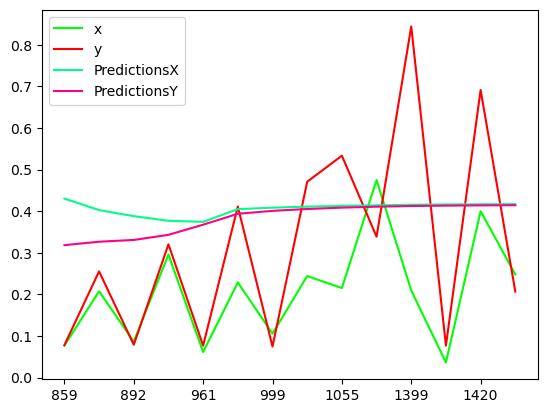

In [62]:
test.plot(color = ['#00FF00', '#FF0000', '#00FF88', '#FF0088'])

In [63]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(test['x'],test['PredictionsX'])))
print(np.sqrt(mean_squared_error(test['y'],test['PredictionsY'])))

0.23421116461721828
0.23345033378661953
